<a href="https://colab.research.google.com/github/ML-Bioinfo-CEITEC/ECCB2021/blob/main/notebooks/Grad_CAM_G4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up

In [ ]:
from tensorflow import keras as K
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Load and preprocess datasets

In [ ]:
# get train dataset
!wget --quiet https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/penguinn/master/Datasets/train_set_1_1.txt

nucleo_dic = {
    "A": 0,
    "C": 1,
    "T": 2,
    "G": 3,
    "N": 4,
}

df_train = pd.read_csv("train_set_1_1.txt", sep='\t', names=['sequence', 'label'])

# translate text labels to numbers 0, 1
labels_train = np.array(list(map((lambda x: 1 if x == 'positive' else 0), list(df_train['label']))))
dataset_train = df_train['sequence'].tolist()
# numericalize using the dictionary
dataset_ordinal_train = [[nucleo_dic[letter] for letter in sequence] for sequence in dataset_train]
# translate number values to one-hot vectors
dataset_onehot_train = tf.one_hot(dataset_ordinal_train, depth=5)


In [ ]:
# get test dataset
!wget --quiet https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/penguinn/master/Datasets/test_set_1_1.txt

# preprocess the test set similarly
df_test = pd.read_csv("test_set_1_1.txt", sep='\t', names=['sequence', 'label'])

labels_test = np.array(list(map((lambda x: 1 if x == 'positive' else 0), list(df_test['label']))))
dataset_test = df_test['sequence'].tolist()

# we use the same nucleo_dic as on the example before
dataset_ordinal_test = [[nucleo_dic[letter] for letter in sequence] for sequence in dataset_test]
dataset_onehot_test = tf.one_hot(dataset_ordinal_test, depth=5)

In [ ]:
# Make the training dataset smaller to demonstrate overfitting.
number_of_examples = 1000

print(dataset_onehot_train[0:number_of_examples].shape)
print(labels_train[0:number_of_examples].shape)

dataset_onehot_train_small = dataset_onehot_train[0:number_of_examples]
labels_train_small = labels_train[0:number_of_examples]

(1000, 200, 5)
(1000,)


In [ ]:
# sequence_size = length of the sequence
sequence_size = 200
# channel = each channel corresponds to a nucleotide
channel = len(nucleo_dic)

## Model with dropout

In [ ]:
# create the NN model

dropout_rate = 0.2

model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(
    filters=10,
    kernel_size=6,
    strides=1,
    padding='same',
    data_format="channels_last",
    activation='relu',
    input_shape=(sequence_size, channel)),

  tf.keras.layers.Dropout(dropout_rate),

  tf.keras.layers.Conv1D(
    filters=10,
    kernel_size=6,
    strides=1,
    padding='same',
    data_format="channels_last",
    activation='relu',
    name="last_conv"),

  tf.keras.layers.Dropout(dropout_rate),
  
  tf.keras.layers.Flatten(),
  
  tf.keras.layers.Dense(10, activation="relu"),
  
  tf.keras.layers.Dropout(dropout_rate),

  tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = K.optimizers.Adam()

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
num_epochs=20
validation_split=0.2

history = model.fit(
    dataset_onehot_train_small,
    labels_train_small,
    batch_size=32,
    epochs=num_epochs,
    # notice the validation split, this split is always taken from the end of the training dataset before shuffle
    #   so, as long as our dataset is the same, train-validation split will also be the same
    validation_split=validation_split
)

Epoch 1/20
25/25 [==============================] - 3s 12ms/step - loss: 0.6897 - accuracy: 0.5450 - val_loss: 0.6737 - val_accuracy: 0.5200
Epoch 2/20
25/25 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6562 - val_loss: 0.5469 - val_accuracy: 0.8300
Epoch 3/20
25/25 [==============================] - 0s 4ms/step - loss: 0.4297 - accuracy: 0.8087 - val_loss: 0.3413 - val_accuracy: 0.8750
Epoch 4/20
25/25 [==============================] - 0s 4ms/step - loss: 0.3085 - accuracy: 0.8612 - val_loss: 0.3175 - val_accuracy: 0.8800
Epoch 5/20
25/25 [==============================] - 0s 4ms/step - loss: 0.2711 - accuracy: 0.8850 - val_loss: 0.3015 - val_accuracy: 0.8800
Epoch 6/20
25/25 [==============================] - 0s 4ms/step - loss: 0.2753 - accuracy: 0.8875 - val_loss: 0.3269 - val_accuracy: 0.8700
Epoch 7/20
25/25 [==============================] - 0s 4ms/step - loss: 0.2650 - accuracy: 0.8938 - val_loss: 0.2953 - val_accuracy: 0.8850
Epoch 8/20
25/25 [=

## Plot learning curves

In [ ]:
metrics = model.evaluate(
    dataset_onehot_test,
    labels_test,
    verbose=0
)


In [ ]:
print('dropout model evaluation on unknown (that is "test") dataset [loss, accuracy]:', metrics)

# Simple trick for the visualization
for met in range(len(metrics)):
  repeted_list = []
  for i in range(len(history.history['accuracy'])):
    repeted_list.append(metrics[met])
  metrics[met] = repeted_list
# print(metrics)


dropout model evaluation on unknown (that is "test") dataset [loss, accuracy]: [0.2906227111816406, 0.8901399970054626]


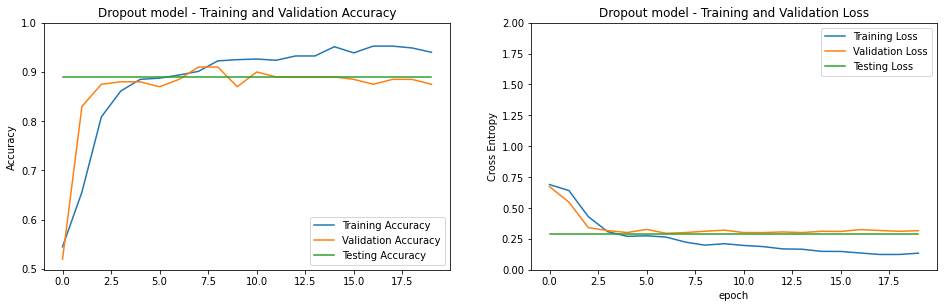

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 10))
# acc
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot(metrics[1], label='Testing Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Dropout model - Training and Validation Accuracy')

# loss
plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot(metrics[0], label='Testing Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Dropout model - Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Define Grad-CAM

In [ ]:
import tensorflow.keras as keras
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3), 1 being the batch size
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    # heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



# Apply Grad-CAM

In [ ]:
def apply_gradcam(test_sample):
  # It is common to name our layers in more complex NNs
  # f.e: model.add(Dense(units = 10, name="dense_1"))
  last_conv_layer_name = "last_conv"

  sample = tf.reshape(test_sample, [-1,200,5])
  preds = model.predict(sample)
  print("Predicted:", preds)

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(sample, model, last_conv_layer_name)

  print(test_sample.shape)
  print(heatmap.shape)
  # Display heatmap
  plt.matshow([heatmap, heatmap, heatmap])
  plt.show()
  
  return heatmap

# Visualize

In [ ]:
import seaborn as sb
def plot_heatmap(df_to_vis):
  ticks = "auto"
  fig, ax = plt.subplots(figsize=(25, 2.8))
  sb.heatmap(df_to_vis[:100].T, cmap="Blues", annot=False, vmin = 0, vmax = 1, xticklabels=ticks, yticklabels=ticks, cbar_kws={"orientation": "horizontal"}, ax=ax, cbar=False)
  ax.invert_yaxis()
  plt.show()

  fig, ax = plt.subplots(figsize=(25, 4))
  sb.heatmap(df_to_vis[100:].T, cmap="Blues", annot=False, vmin = 0, vmax = 1, xticklabels=ticks, yticklabels=ticks, cbar_kws={"orientation": "horizontal"}, ax=ax)
  ax.invert_yaxis()
  plt.show()

# Use it all together

Predicted: [[0.02440628]]
(200, 5)
(200,)


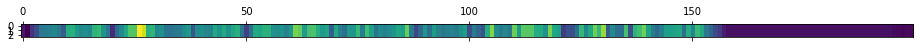

In [ ]:
sample_num = 2
heatmap = apply_gradcam(dataset_onehot_test[sample_num])

In [ ]:
print(df_test['sequence'][sample_num])
print(labels_test[sample_num])

NNNNTTGTTCTCTTCTTAGTTCCTTGAGGAGCAACATTATGTTATTTGAGCTCTTTCTTCTTTTTGATATAGGCATTTATTGCTGCAAACATTGATCTTACTGCTTTTGCTGTATTTCATAAGCTTTTGGTATGTTGTGTTTCCATTTTTGTTTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
0


In [ ]:
chars = [char for char in dataset_test[sample_num]]
visualize_1 = pd.DataFrame(heatmap.reshape((200,1)), chars)
visualize_1

,0
N,0.147943
N,0.085242
N,0.226174
N,0.305971
T,0.448673
...,...
N,0.112942
N,0.107698
N,0.100946
N,0.107854


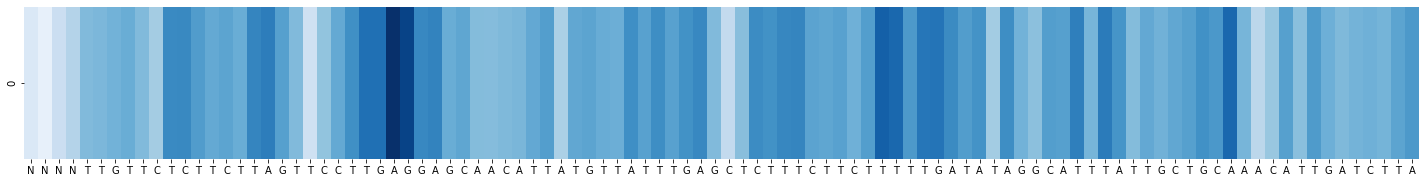

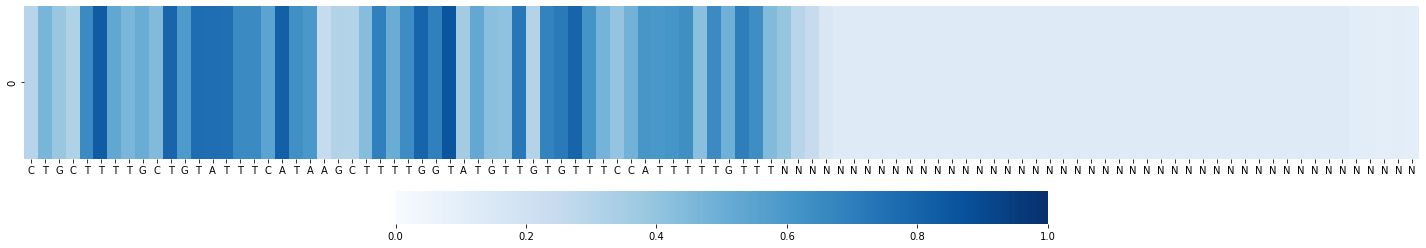

In [ ]:
plot_heatmap(visualize_1)

This one did not have G4 in it. Let's try an example containing G4 structure.

Predicted: [[0.9976628]]
(200, 5)
(200,)


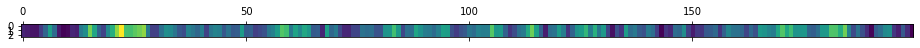

df_test  AACCCGGGTCCCCTGGGTCCGGGGTGGGGTCGGTTAAGGTAGTGGTTCAAGAAACTGGAGGTGAGGACTGTAACTTGGTCTAGGGACGAGAAGGAGGACGATAGGGGTAACAGGGGACAGGGTCGGTGAGAGTCGTGTATGGACCCAGTAATCTGTCTAGGACAGAGGGCGGAGAGGACGGAGGGGACGACCGGAACAAT
labels_test  1


In [ ]:
sample_num = 1
heatmap = apply_gradcam(dataset_onehot_test[sample_num])

print('df_test ', df_test['sequence'][sample_num])
print('labels_test ', labels_test[sample_num])

chars = [char for char in dataset_test[sample_num]]
visualize_2 = pd.DataFrame(heatmap.reshape((200,1)), chars)


labels_test  0


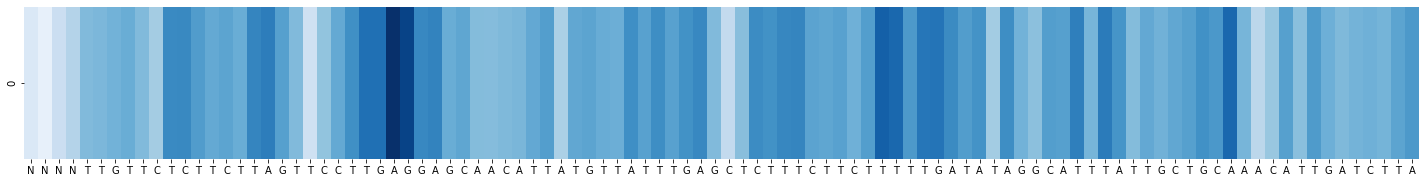

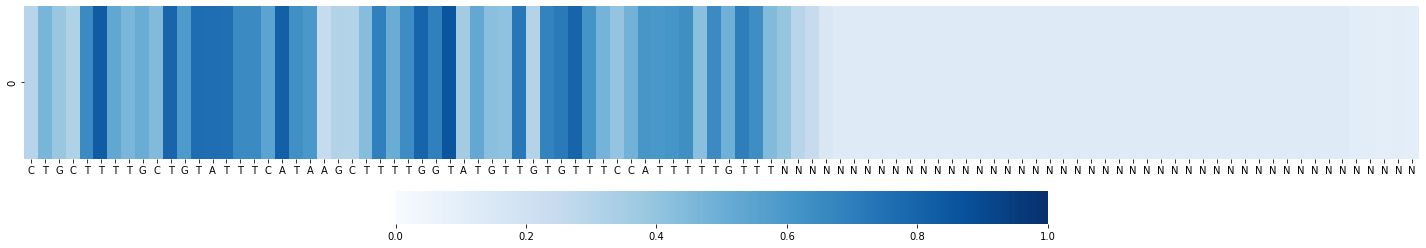

labels_test  1


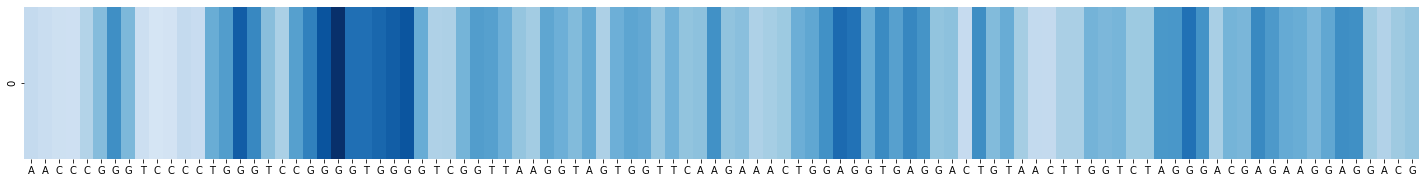

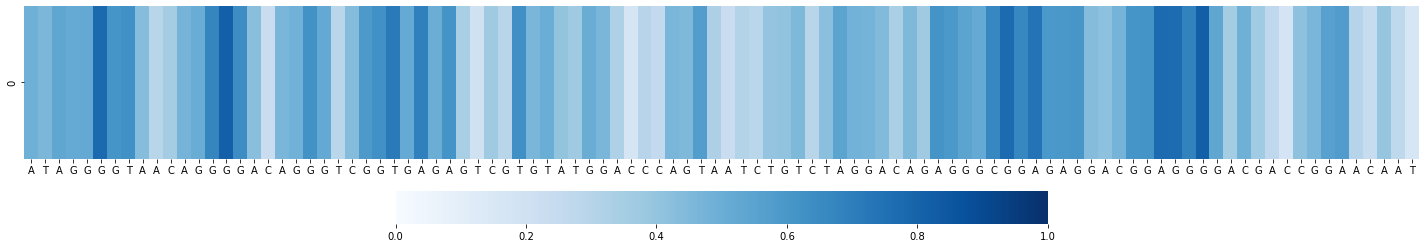

In [ ]:
print('label ', labels_test[2])
plot_heatmap(visualize_1)

print('label ', labels_test[1])
plot_heatmap(visualize_2)

